# **Multi-inference implicit chain of reasoning demonstration**

In this notebook I attempt to solve this challenge [here](https://yuntiandeng.com/cv/challenge.png) by referencing the research paper and source code linked below. We are are trying to create a LLM that can solve simultaneous 2 digit by 2 digit multiplication using implicit chain of thought reasoning. 

| ||
|----------|----------|
| Research Credit | [here](https://arxiv.org/pdf/2311.01460.pdf) |
| Code Inspiration Credit | [github](https://github.com/da03/implicit_chain_of_thought/tree/main) |

- First we train a teacher model to explicity use chain of thought to solve simultaneous 2 digit by 2 digit multiplication. 
- Then we have a thought emulator model to predict teacher states from input. 
- We have a mind reader emulator that predicts the final output from teacher states. 
- Finally we create the implicit student model, which trains using the thought and mindreader emulator simetatnously to implicity use CoT to predict the output from the input.

In [1]:
import sys
import os

#For safe imports of everything
notebook_directory = os.getcwd()
parent_directory = os.path.dirname(notebook_directory)
sys.path.insert(False, parent_directory)

### **Dataset Generation**
Here we generate our test and train data. We generate our training data randomly such that it represents less than **1%** of possible observations. We also generate our tokenized data here as well.

---

The format of training and test datasets follow this format:

```
[input 1a] $ [input 1b]||[CoT 1a] $ [CoT 1b] #### [output 1a] $ [output 1b]
[input 2a] $ [input 2b]||[CoT 2a] $ [CoT 2b] #### [output 2a] $ [output 2b]
[input 3a] $ [input 3b]||[CoT 3a] $ [CoT 3b] #### [output 3a] $ [output 3b]
```

We can also test any particular case using the DatasetHandler so we create a custom prediction dataset as well.

In [2]:
from data.data import DatasetHandler

training_data_size = 77700
test_data_size = 7700

datahandler_train = DatasetHandler(parent_path = parent_directory, max_len = 1024, type = 'train')
datahandler_test = DatasetHandler(parent_path = parent_directory, max_len = 1024, type = 'test')

Now we generate datasets for each handler.

In [3]:
datahandler_train.generateDataset(size = training_data_size)


Generated raw train dataset saved at c:\Users\Luke\multi_implicit_cot\data\raw_train_dataset.txt of size 77700.
Creating tokenized features from dataset file at c:\Users\Luke\multi_implicit_cot\data\raw_train_dataset.txt
tgt_avg:  20.0
src_avg:  12.0
ratios:  0.6
tgt_avg:  14.0
src_avg:  12.0
ratios:  0.8571428571428571
---------------------------
Example features:
Full entry:  9 5 * 4 8 $ 1 7 * 4 7 <|endoftext|> 6 3 2 + 0 2 7 4 $ 4 8 2 + 0 7 9 4 <|endoftext|> #### 6 5 9 4 $ 4 5 2 5 <|endoftext|>
No CoT:  9 5 * 4 8 $ 1 7 * 4 7 <|endoftext|> #### 6 5 9 4 $ 4 5 2 5 <|endoftext|>
Only CoT:  9 5 * 4 8 $ 1 7 * 4 7 <|endoftext|> 6 3 2 + 0 2 7 4 $ 4 8 2 + 0 7 9 4 <|endoftext|>
Product input:  9 5 * 4 8 $ 1 7 * 4 7 <|endoftext|> 
---------------------------


In [4]:
datahandler_test.generateDataset(size = test_data_size)

Generated raw test dataset saved at c:\Users\Luke\multi_implicit_cot\data\raw_test_dataset.txt of size 7700.
Creating tokenized features from dataset file at c:\Users\Luke\multi_implicit_cot\data\raw_test_dataset.txt
tgt_avg:  20.0
src_avg:  12.0
ratios:  0.6
tgt_avg:  14.0
src_avg:  12.0
ratios:  0.8571428571428571
---------------------------
Example features:
Full entry:  3 1 * 9 0 $ 4 9 * 6 6 <|endoftext|> 7 1 1 + 0 0 0 0 $ 4 6 5 + 0 4 6 5 <|endoftext|> #### 7 1 1 0 $ 4 0 2 6 <|endoftext|>
No CoT:  3 1 * 9 0 $ 4 9 * 6 6 <|endoftext|> #### 7 1 1 0 $ 4 0 2 6 <|endoftext|>
Only CoT:  3 1 * 9 0 $ 4 9 * 6 6 <|endoftext|> 7 1 1 + 0 0 0 0 $ 4 6 5 + 0 4 6 5 <|endoftext|>
Product input:  3 1 * 9 0 $ 4 9 * 6 6 <|endoftext|> 
---------------------------


Here we allow the creation of a **custom prediction** using input from the jupyter kernel, press enter after each integer. The custom prediction is of the form **a*b** and **c*d**.

In [5]:
#Please provide inputs for the custom test case. Press enter after each integer.
a= int(input("provide int a: "))
b= int(input("provide int b: "))
c= int(input("provide int c: "))
d= int(input("provide int d: "))

print(f"You have provided the input {a}*{b} and {c}*{d} which equals {a*b} and {c*d} respectively.")

custom_prediction = DatasetHandler(parent_path = parent_directory, max_len = 1024, type = 'custom')
custom_prediction.generateDataset(a=a, b=b, c=c, d=d)

You have provided the input 1*2 and 3*4 which equals 2 and 12 respectively.
Generated raw custom dataset saved at c:\Users\Luke\multi_implicit_cot\data\raw_custom_dataset.txt of size 1.
Creating tokenized features from dataset file at c:\Users\Luke\multi_implicit_cot\data\raw_custom_dataset.txt
tgt_avg:  20.0
src_avg:  12.0
ratios:  0.6
tgt_avg:  14.0
src_avg:  12.0
ratios:  0.8571428571428571
---------------------------
Example features:
Full entry:  1 0 * 2 0 $ 3 0 * 4 0 <|endoftext|> 2 0 0 + 0 0 0 0 $ 2 1 0 + 0 0 0 0 <|endoftext|> #### 2 0 0 0 $ 2 1 0 0 <|endoftext|>
No CoT:  1 0 * 2 0 $ 3 0 * 4 0 <|endoftext|> #### 2 0 0 0 $ 2 1 0 0 <|endoftext|>
Only CoT:  1 0 * 2 0 $ 3 0 * 4 0 <|endoftext|> 2 0 0 + 0 0 0 0 $ 2 1 0 + 0 0 0 0 <|endoftext|>
Product input:  1 0 * 2 0 $ 3 0 * 4 0 <|endoftext|> 
---------------------------


### **Model Training**
Here we begin training our individual models. First we import everything we need.

---


In [6]:
from source.teacher import Teacher
from source.configurations import TeacherConfig

from source.thought_emulator import ThoughtEmulator
from source.configurations import ThoughtEmulatorConfig

from source.mindreading_emulator import MindReadingEmulator
from source.configurations import MindReadingEmulatorConfig

from source.implicit_student import ImplicitStudent

Now we initialize the configurations and models.

In [7]:
teacher_config = TeacherConfig()
teacher_model = Teacher(teacher_config)

t_emulator_config = ThoughtEmulatorConfig()
t_emulator_model = ThoughtEmulator(t_emulator_config, teacher_model)

mr_emulator_config = MindReadingEmulatorConfig()
mr_emulator_model = MindReadingEmulator(mr_emulator_config, teacher_model)

implicit_model = ImplicitStudent(mr_emulator_config, mindread = mr_emulator_model, thought = t_emulator_model)

##### **Teacher Model**
This model takes in inputs and generates a CoT and product as output.

  0%|          | 1/2429 [00:01<1:01:58,  1.53s/it]

Step: 0. PPL: 108.721741. Training Accuracy: 0.157227


 10%|█         | 244/2429 [01:19<11:53,  3.06it/s]

Step: 243. PPL: 1.873628. Training Accuracy: 0.759766


 20%|██        | 487/2429 [02:36<10:12,  3.17it/s]

Step: 486. PPL: 1.343377. Training Accuracy: 0.895508


 30%|███       | 730/2429 [03:54<08:49,  3.21it/s]

Step: 729. PPL: 1.158295. Training Accuracy: 0.948242


 40%|████      | 973/2429 [05:11<07:34,  3.20it/s]

Step: 972. PPL: 1.088497. Training Accuracy: 0.971680


 49%|████▉     | 1197/2429 [06:23<06:34,  3.12it/s]


Accuracy limit reached, stopping training at training accuracy: 0.990234.
✔ Evaluating test dataset now...


100%|██████████| 241/241 [02:13<00:00,  1.80it/s]

Input:  6 7 * 2 2 $ 1 8 * 9 3 
Target:  2 5 1 + 0 2 5 1 $ 9 2 7 + 0 3 4 2  #### 2 7 6 1 $ 9 5 1 3 
Predicted:  2 5 1 + 0 2 5 1 $ 9 2 7 + 0 3 4 2  #### 2 7 6 1 $ 9 5 1 3 

Input:  3 9 * 6 7 $ 3 5 * 5 9 
Target:  8 5 5 + 0 1 5 6 $ 5 6 2 + 0 7 7 4  #### 8 6 0 7 $ 5 3 0 5 
Predicted:  8 5 5 + 0 1 5 6 $ 5 6 2 + 0 7 7 4  #### 8 6 0 7 $ 5 3 0 5 

Input:  7 5 * 2 0 $ 2 4 * 3 5 
Target:  4 1 1 + 0 0 0 0 $ 6 2 1 + 0 0 1 2  #### 4 1 1 0 $ 6 2 2 2 
Predicted:  4 1 1 + 0 0 0 0 $ 6 2 1 + 0 0 1 2  #### 4 1 1 0 $ 6 2 2 2 

→ Perplexitity: 1.020954; Test Accuracy: 0.811429; Training Accuracy: 0.993364.
Saving to c:\Users\Luke\multi_implicit_cot\models\teacher


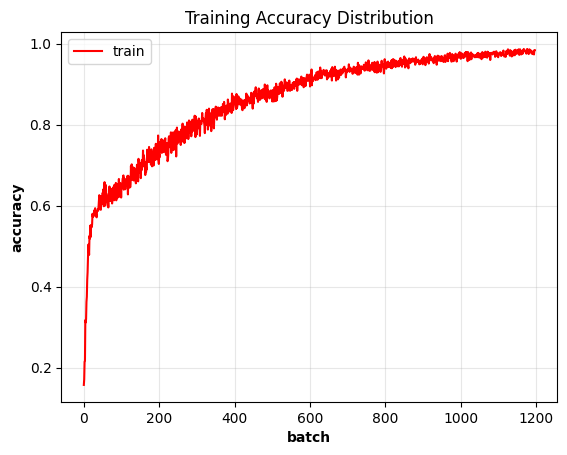

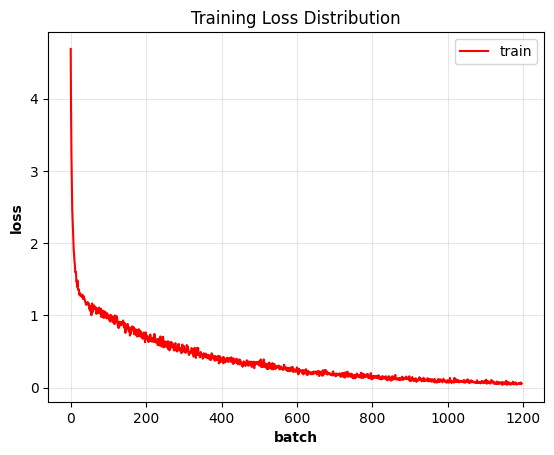

In [8]:
teacher_model.train(train_handler = datahandler_train, test_handler = datahandler_test, limit = 0.9999)

##### **Thought Emulator Model**
This model takes the input and predicts the teacher states. We calculate a proxy for accuracy by taking the mean difference in layer states between the teacher model and itself.

  0%|          | 1/2429 [00:00<34:22,  1.18it/s]

Step: 0. Loss: 9697.629883. Quasi Training Accuracy: 0.082393.


 10%|█         | 244/2429 [01:37<14:29,  2.51it/s]

Step: 243. Loss: 336.903015. Quasi Training Accuracy: 0.821303.


 20%|██        | 487/2429 [03:14<12:48,  2.53it/s]

Step: 486. Loss: 269.262146. Quasi Training Accuracy: 0.845723.


 30%|███       | 730/2429 [04:50<11:37,  2.44it/s]

Step: 729. Loss: 232.267334. Quasi Training Accuracy: 0.857423.


 40%|████      | 973/2429 [06:24<09:12,  2.63it/s]

Step: 972. Loss: 190.745255. Quasi Training Accuracy: 0.872996.


 50%|█████     | 1216/2429 [07:58<07:37,  2.65it/s]

Step: 1215. Loss: 157.314606. Quasi Training Accuracy: 0.887087.


 60%|██████    | 1459/2429 [09:31<06:07,  2.64it/s]

Step: 1458. Loss: 131.714417. Quasi Training Accuracy: 0.895920.


 70%|███████   | 1702/2429 [11:05<04:34,  2.64it/s]

Step: 1701. Loss: 134.131546. Quasi Training Accuracy: 0.895636.


 80%|████████  | 1945/2429 [12:41<03:11,  2.52it/s]

Step: 1944. Loss: 124.425056. Quasi Training Accuracy: 0.897695.


 90%|█████████ | 2188/2429 [14:15<01:30,  2.65it/s]

Step: 2187. Loss: 97.979248. Quasi Training Accuracy: 0.910235.


100%|██████████| 2429/2429 [15:47<00:00,  2.56it/s]


✔ Evaluating test dataset now...


100%|██████████| 241/241 [00:29<00:00,  8.28it/s]


Input:  1 9 * 2 6 $ 1 5 * 7 1  
Target H. Layer 1, V. Layer 1, first 9 states:
[ 0.3296 -0.0993  0.8901 -0.2541 -0.3673  0.2396 -1.2877 -0.2383 -0.3711]
Predicted H. Layer 1, V. Layer 1, first 9 states: 
[ 0.3363 -0.0931  0.8653 -0.2466 -0.3683  0.2471 -1.2917 -0.2458 -0.3359]

Input:  1 9 * 2 6 $ 1 5 * 7 1  
Target H. Layer 1, V. Layer 1, first 9 states:
[ 0.3296 -0.0993  0.8901 -0.2541 -0.3673  0.2396 -1.2877 -0.2383 -0.3711]
Predicted H. Layer 1, V. Layer 1, first 9 states: 
[ 0.3363 -0.0931  0.8653 -0.2466 -0.3683  0.2471 -1.2917 -0.2458 -0.3359]

Input:  1 9 * 2 6 $ 1 5 * 7 1  
Target H. Layer 1, V. Layer 1, first 9 states:
[ 0.3296 -0.0993  0.8901 -0.2541 -0.3673  0.2396 -1.2877 -0.2383 -0.3711]
Predicted H. Layer 1, V. Layer 1, first 9 states: 
[ 0.3363 -0.0931  0.8653 -0.2466 -0.3683  0.2471 -1.2917 -0.2458 -0.3359]

→ Loss: 74.228353; Quasi Test Accuracy: 0.919996; Quasi Training Accuracy: 0.916659.
Saving to c:\Users\Luke\multi_implicit_cot\models\thought_emulator


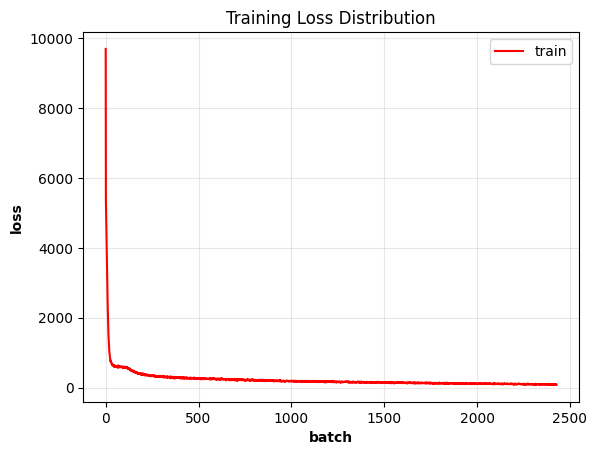

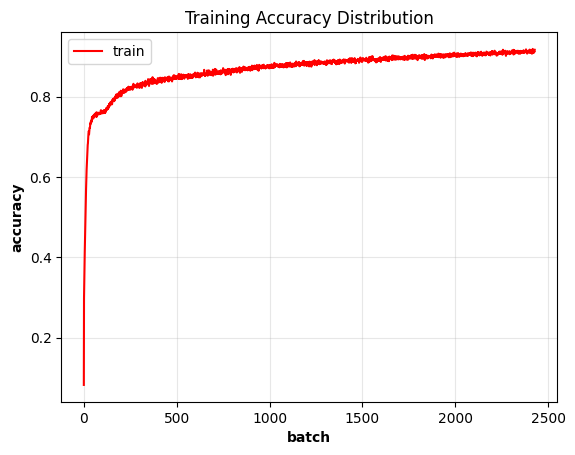

In [9]:
t_emulator_model.train(train_handler = datahandler_train, test_handler = datahandler_test, limit = 0.9999)

##### **Mind Reading Emulator Model**
This model takes in the teacher states as input and predicts the output.

  0%|          | 1/2429 [00:00<30:04,  1.35it/s]

Step: 0. Loss: 6.380478. Training Accuracy: 0.026442.


 10%|█         | 244/2429 [02:25<25:28,  1.43it/s]

Step: 243. Loss: 0.931292. Training Accuracy: 0.622596.


 20%|██        | 487/2429 [04:57<22:02,  1.47it/s]

Step: 486. Loss: 0.667287. Training Accuracy: 0.735577.


 30%|███       | 730/2429 [07:41<17:41,  1.60it/s]

Step: 729. Loss: 0.529882. Training Accuracy: 0.790865.


 40%|████      | 973/2429 [10:15<14:29,  1.67it/s]

Step: 972. Loss: 0.426715. Training Accuracy: 0.836538.


 50%|█████     | 1216/2429 [12:54<13:05,  1.54it/s]

Step: 1215. Loss: 0.337932. Training Accuracy: 0.875000.


 60%|██████    | 1459/2429 [15:20<09:24,  1.72it/s]

Step: 1458. Loss: 0.286496. Training Accuracy: 0.884615.


 70%|███████   | 1702/2429 [17:42<06:38,  1.83it/s]

Step: 1701. Loss: 0.298200. Training Accuracy: 0.877404.


 80%|████████  | 1945/2429 [20:04<04:30,  1.79it/s]

Step: 1944. Loss: 0.335987. Training Accuracy: 0.865385.


 90%|█████████ | 2188/2429 [22:40<02:30,  1.60it/s]

Step: 2187. Loss: 0.267779. Training Accuracy: 0.889423.


100%|██████████| 2429/2429 [24:56<00:00,  1.62it/s]


✔ Evaluating test dataset now...


100%|██████████| 241/241 [19:32<00:00,  4.86s/it]

Input H. Layer 1, V. Layer 1, first 9 states:
[ 0.3296 -0.0993  0.8901 -0.2541 -0.3673  0.2396 -1.2877 -0.2383 -0.3711]
Target:  #### 2 7 6 1 $ 9 5 1 3 
Predicted:  #### 2 9 6 1 $ 9 5 1 3 

Input H. Layer 1, V. Layer 1, first 9 states:
[ 0.3296 -0.0993  0.8901 -0.2541 -0.3673  0.2396 -1.2877 -0.2383 -0.3711]
Target:  #### 8 6 0 7 $ 5 3 0 5 
Predicted:  #### 8 3 1 7 $ 5 4 0 5 

Input H. Layer 1, V. Layer 1, first 9 states:
[ 0.3296 -0.0993  0.8901 -0.2541 -0.3673  0.2396 -1.2877 -0.2383 -0.3711]
Target:  #### 4 1 1 0 $ 6 2 2 2 
Predicted:  #### 4 3 1 0 $ 6 8 1 2 

→ Perplexitity: 1.259585; Test Accuracy: 0.151948; Training Accuracy: 0.904705.
Saving to c:\Users\Luke\multi_implicit_cot\models\mindreading_emulator


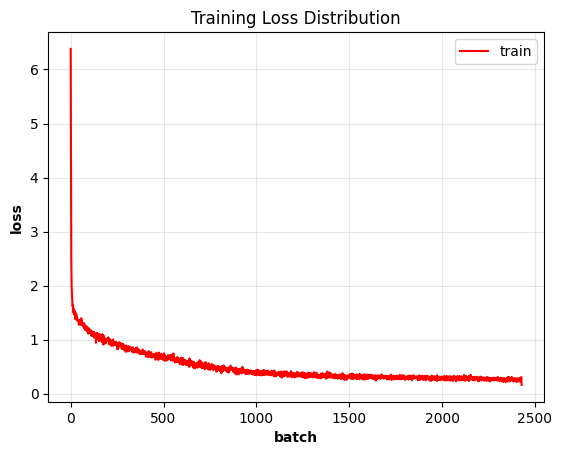

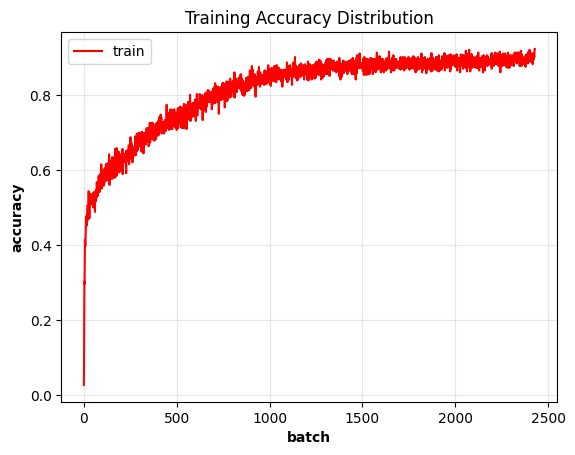

In [10]:
mr_emulator_model.train(train_handler = datahandler_train, test_handler = datahandler_test, limit = 0.9999)

##### **Implicit Model**
This model takes the input and predicts teacher states, and uses the teacher states to predict the output. The teacher states are used implicitly to mimic CoT reasoning internally. It trains using both the thought emulator and the mind emulator model.

  0%|          | 0/2429 [00:00<?, ?it/s]

  0%|          | 1/2429 [00:00<29:12,  1.39it/s]

Step: 0. Loss: 0.275477. Training Accuracy: 0.884615.


 10%|█         | 244/2429 [01:59<17:16,  2.11it/s]

Step: 243. Loss: 0.229418. Training Accuracy: 0.901442.


 20%|██        | 487/2429 [04:00<16:28,  1.96it/s]

Step: 486. Loss: 0.223083. Training Accuracy: 0.906250.


 30%|███       | 730/2429 [06:02<15:01,  1.88it/s]

Step: 729. Loss: 0.166046. Training Accuracy: 0.923077.


 40%|████      | 973/2429 [08:13<12:40,  1.91it/s]

Step: 972. Loss: 0.161362. Training Accuracy: 0.944712.


 50%|█████     | 1216/2429 [10:22<11:21,  1.78it/s]

Step: 1215. Loss: 0.165897. Training Accuracy: 0.930288.


 60%|██████    | 1459/2429 [12:34<09:36,  1.68it/s]

Step: 1458. Loss: 0.123087. Training Accuracy: 0.951923.


 70%|███████   | 1702/2429 [14:37<05:59,  2.02it/s]

Step: 1701. Loss: 0.114662. Training Accuracy: 0.954327.


 80%|████████  | 1945/2429 [16:44<04:15,  1.89it/s]

Step: 1944. Loss: 0.092173. Training Accuracy: 0.968750.


 89%|████████▉ | 2173/2429 [18:45<02:12,  1.93it/s]


Training accuracy limit reached, stopping training at training accuracy: 0.990385.
✔ Evaluating test dataset now...


100%|██████████| 241/241 [21:10<00:00,  5.27s/it]

Input:  6 7 * 2 2 $ 1 8 * 9 3 
Target:  #### 2 7 6 1 $ 9 5 1 3 
Predicted:  #### 2 7 6 1 $ 9 5 1 3 

Input:  3 9 * 6 7 $ 3 5 * 5 9 
Target:  #### 8 6 0 7 $ 5 3 0 5 
Predicted:  #### 8 4 0 7 $ 5 3 0 5 

Input:  7 5 * 2 0 $ 2 4 * 3 5 
Target:  #### 4 1 1 0 $ 6 2 2 2 
Predicted:  #### 4 1 1 0 $ 6 2 2 2 

→ Perplexitity: 1.074952; Test Accuracy: 0.684156; Training Accuracy: 0.973507.
Saving to c:\Users\Luke\multi_implicit_cot\models\implict_thought_emulator


Saving to c:\Users\Luke\multi_implicit_cot\models\implict_mindreading_emulator


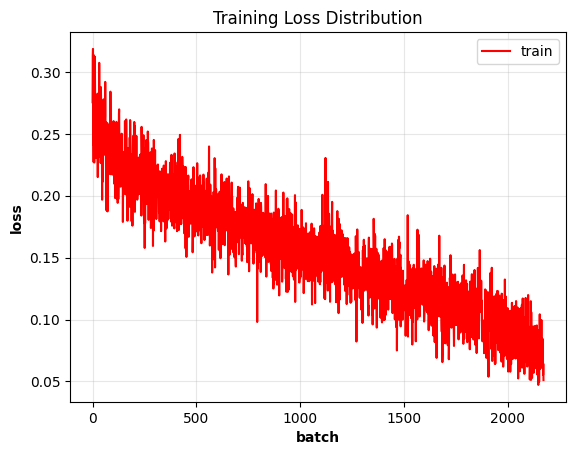

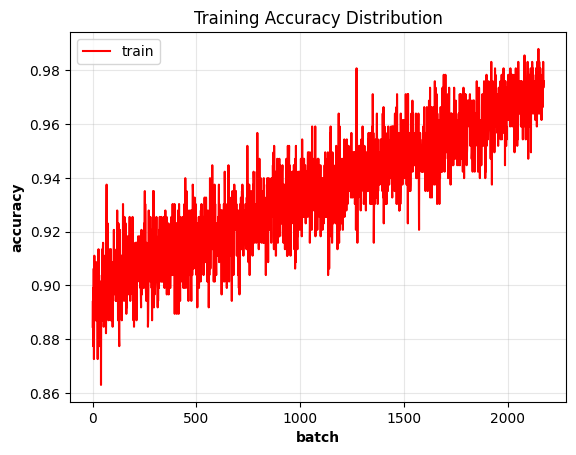

In [11]:
implicit_model.train(train_handler = datahandler_train, test_handler = datahandler_test, limit = 0.9999)

### **Prediction Demo**
Here we generate our custom test case to see results for each model. We include both the **thought emulator** and **mind reading emulator** to see how well it maps to and from teacher states.

---

In [12]:
teacher_model.predict(custom_prediction)

100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

Input:  1 0 * 2 0 $ 3 0 * 4 0 
Target:  2 0 0 + 0 0 0 0 $ 2 1 0 + 0 0 0 0  #### 2 0 0 0 $ 2 1 0 0 
Predicted:  2 0 0 + 0 0 0 0 $ 2 1 0 + 0 0 0 0  #### 2 0 0 0 $ 2 1 0 0 



In [13]:
t_emulator_model.predict(custom_prediction)

100%|██████████| 1/1 [00:00<00:00, 15.02it/s]

Input:  1 0 * 2 0 $ 3 0 * 4 0  
Target H. Layer 1, V. Layer 1, first 9 states:
[ 0.3296 -0.0993  0.8901 -0.2541 -0.3673  0.2396 -1.2877 -0.2383 -0.3711]
Predicted H. Layer 1, V. Layer 1, first 9 states: 
[ 0.3364 -0.0931  0.8652 -0.2466 -0.3683  0.2472 -1.2917 -0.2458 -0.3358]


In [14]:
mr_emulator_model.predict(custom_prediction)

100%|██████████| 1/1 [00:00<00:00,  5.33it/s]

Input H. Layer 1, V. Layer 1, first 9 states:
[ 0.3296 -0.0993  0.8901 -0.2541 -0.3673  0.2396 -1.2877 -0.2383 -0.3711]
Target:  #### 2 0 0 0 $ 2 1 0 0 
Predicted:  #### 2 0 0 0 $ 2 1 0 0 



In [15]:
implicit_model.predict(custom_prediction)

100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

Input:  1 0 * 2 0 $ 3 0 * 4 0 
Target:  #### 2 0 0 0 $ 2 1 0 0 
Predicted:  #### 2 0 0 0 $ 2 1 0 0 

